# Aggregating manual annotations and correlations

We read the evaluation results from excel files that have the following columns:

Turn	
Speaker	
Cue	
Response	
Context

System ratings
* MLM response	
* System llh	
* MLM llh	
* USR DLcontext	
* USR DLfact	

Human ratings:
* Overall Human Rating	
* Interesting	
* Engaging	
* Specific	
* Relevant	
* Correct	
* Semantically Appropriate	
* Understandable	
* Fluent

In [1]:
# Needed to calculate the mean square error for regression scores
#! pip install sklearn

In [2]:
### Needed to read Ecel files: xlsx
# ! pip install openpyxl

In [1]:
from pathlib import Path
import glob
import pandas as pd
import json
import math
import numpy as np
import matplotlib.pyplot as plt

group = "g1-piek"
#group = "g2-jaap"
#group = "g3-lea"
#group = "g4-tae"
annotation_path = "/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/"+group+"/scenario2"
#annotation_path = "."
basepath = Path(annotation_path)

In [51]:
def get_score_triples_from_turn(json_row:str, speaker_scores:{}, auto_score:str, hum_score:str):
    speaker = json_row['Speaker']
    turn = json_row['Turn']
    auto = json_row[auto_score]
    hum = json_row[hum_score]
    triple = (turn, auto, hum)
    if not speaker_scores.get(speaker):
        speaker_scores[speaker]=[]
    speaker_scores[speaker].append(triple)
    
def evaluate_regression_scores(basepath:Path, speaker_scores:{},auto_score:str, hum_score:str):
    turn_index =[]
    speaker_scores:{}
    for path in basepath.glob('*.csv'):
        df = pd.read_csv(path)
        print(path)
        js = df.to_json(orient = 'records')
        for turn in json.loads(js):
            get_score_triples_from_turn(turn, speaker_scores, auto_score,hum_score)

def get_scores_for_turns(json_row:str, turn_scores:{}, score_name:str):
    turn = json_row['Turn']
    score = json_row[score_name]
    if score:
        if not turn_scores.get(turn):
            turn_scores[turn]=[]
        turn_scores[turn].append(score)

def get_score_for_turns(json_row:str, turn_scores:{}, score_name:str):
    turn = json_row['Turn']
    score = json_row[score_name]
    if score:
        turn_scores[turn]= score

def get_normalized_human_scores(basepath:Path, score_name:str):
    all_turn_scores = {}
    normalized_scores = {}
    averaged_score = []
    for path in basepath.glob('*.csv'):
        df = pd.read_csv(path)
        if 'Turn' in df:
            print(path)
            js = df.to_json(orient = 'records')
            turn_scores={}
            for turn in json.loads(js):
                get_scores_for_turns(turn, turn_scores, score_name)
            for turn_id in turn_scores:
                if not all_turn_scores.get(turn_id):
                    all_turn_scores[turn_id]=[]
                all_turn_scores[turn_id].extend(turn_scores[turn_id])

    for turn_id in all_turn_scores:
        scores = all_turn_scores[turn_id]
        average = sum(scores)/len(scores)
        averaged_score.append(average)
        normalized_score = (average-1)/4
        normalized_scores[turn_id]=normalized_score
    averaged_score = sum(averaged_score)/len(averaged_score)
    #print(normalized_scores)
    #print(averaged_score)
    return normalized_scores, averaged_score

## Averaging the human annotations 

In [52]:
score_name = "Overall Human Rating"
normalized_scores_overall, average_overall = get_normalized_human_scores(basepath, score_name)

score_name = "Interesting"
normalized_scores_interesting, average_interesting = get_normalized_human_scores(basepath, score_name)

score_name = "Engaging"
normalized_scores_engaging, average_engaging = get_normalized_human_scores(basepath, score_name)

score_name = "Specific"
normalized_scores_specific, average_specific = get_normalized_human_scores(basepath, score_name)

score_name = "Relevant"
normalized_scores_relevant, average_relevant = get_normalized_human_scores(basepath, score_name)

score_name = "Correct"
normalized_scores_correct, average_correct = get_normalized_human_scores(basepath, score_name)

score_name = "Semantically Appropriate"
normalized_scores_semantic, average_semantic = get_normalized_human_scores(basepath, score_name)

score_name = "Understandable"
normalized_scores_understandable, average_understand = get_normalized_human_scores(basepath, score_name)

score_name = "Fluent"
normalized_scores_fluent, average_fluent = get_normalized_human_scores(basepath, score_name)

/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g1-piek/scenario2/2021-12-10-09_35_57_turns57_thomas.csv
/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g1-piek/scenario2/2021-12-10-09_35_57_turns57_imme.csv
/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g1-piek/scenario2/2021-12-10-09_35_57_turns57_fina.csv
/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g1-piek/scenario2/2021-12-10-09_35_57_turns57_thomas.csv
/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g1-piek/scenario2/2021-12-10-09_35_57_turns57_imme.csv
/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g1-piek/scenario2/2021-12-10-09_35_57_turns57_fina.csv
/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g1-piek/scenario2/2021-12-10-09_35_57_turns57_thomas.csv
/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g1-piek/scenario2/2021-12-10-09_35_57_turns57_imm

In [53]:
print(average_overall)
print(average_interesting)
print(average_engaging)
print(average_specific)
print(average_relevant)
print(average_correct)
print(average_semantic)
print(average_understand)
print(average_fluent)

3.405797101449275
2.9710144927536235
3.115942028985507
2.8405797101449273
3.855072463768116
3.9275362318840563
3.9130434782608696
4.057971014492753
4.130434782608695


### Visualising the human ratings over turns

In [27]:
def extend__with_bar(width, normalized_scores:{}, score_name:str, plt, colors:[], used_colors):
    turns = list(normalized_scores.keys())
    ###We take all turns from the turn_index to create the x-axis
    x = np.arange(len(turns))
    y = []
    for key in normalized_scores:
        y.append(normalized_scores[key])
    c1 = choice(colors)   
    while c1 in used_colors:
        c1 = choice(colors)
    
    used_colors.append(c1)
    plt.barh(x+width, y,  color=c1, edgecolor="black", label=score_name, height=0.1)
    #plt.bar(x+width, y,  color=c1, width=barWidth, edgecolor="black", label=score_name)

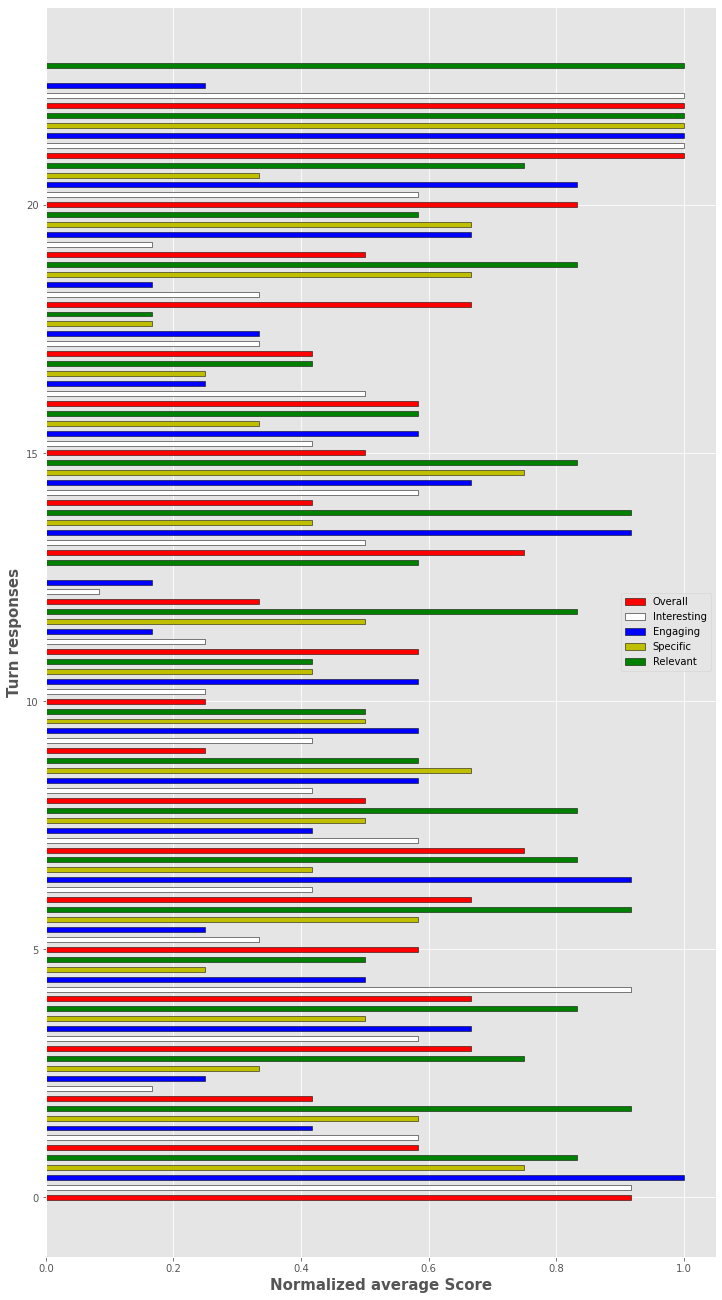

In [28]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

score_name = "Overall"
extend__with_bar(0, normalized_scores_overall, score_name, plt, ["r"], used_colors)

score_name = "Interesting"
extend__with_bar(0.2,normalized_scores_interesting, score_name, plt, colors, used_colors)
score_name = "Engaging"
extend__with_bar(0.4,normalized_scores_engaging, score_name, plt, colors, used_colors)
score_name = "Specific"
extend__with_bar(0.6,normalized_scores_specific, score_name, plt, colors, used_colors)
score_name = "Relevant"
extend__with_bar(0.8,normalized_scores_relevant, score_name, plt, colors, used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

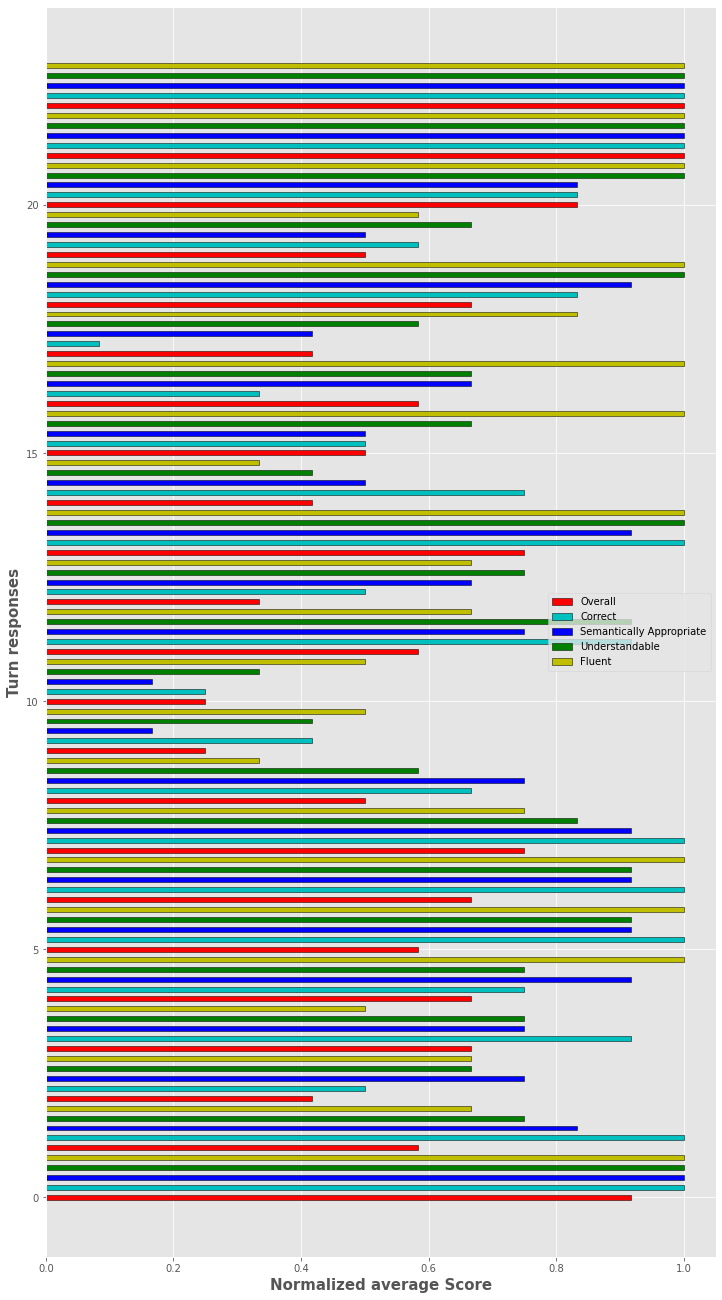

In [29]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

score_name = "Overall"
extend__with_bar(0, normalized_scores_overall, score_name, plt, ["r"], used_colors)

score_name = "Correct"
extend__with_bar(0.2,normalized_scores_correct, score_name, plt, colors, used_colors)
score_name = "Semantically Appropriate"
extend__with_bar(0.4,normalized_scores_semantic, score_name, plt, colors, used_colors)
score_name = "Understandable"
extend__with_bar(0.6,normalized_scores_understandable, score_name, plt, colors, used_colors)
score_name = "Fluent"
extend__with_bar(0.8,normalized_scores_fluent, score_name, plt, colors, used_colors)

plt.style.use('ggplot')
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

### Correlating the human annotations with overall rating

In [30]:
#https://medium.com/analytics-vidhya/mae-mse-rmse-coefficient-of-determination-adjusted-r-squared-which-metric-is-better-cd0326a5697e

from sklearn.metrics import mean_squared_error, mean_absolute_error

def get_mean_error_area(scores_x, scores_y):
    x = []
    for key in scores_x:
        x.append(scores_x[key])
    y = []
    for key in scores_y:
        y.append(scores_y[key])
    #print(score_name_x, "&", score_name_y)
    mae = mean_absolute_error(x, y).round(2)
    mse = mean_squared_error(x, y).round(2)
    rmse = mean_squared_error(x, y, squared=False).round(2)
    #print(f"Mean Absolute Error:", mae)
    #print(f"Mean Squared Error:", mse)
    #print(f"Root Mean Squared Error:", rmse)
    return mae, mse, rmse

In [31]:
rows = []
score_name_x = "Overall Human Rating"

score_name_y = "Interesting"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_interesting)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Engaging"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_engaging)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Specific"
normalized_scores_specific 
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_engaging)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Relevant"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_relevant)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Correct"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_correct)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Semantically Appropriate"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_semantic)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Understandable" 
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_understandable)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Fluent"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_fluent)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

df_scores = pd.DataFrame(rows)
df_scores.head()

file = annotation_path+"/"+score_name_x+"_correlation.csv"
df_scores.to_csv(file, index=False)

## Correlating automated score with the human ratings

### System likelihood of the agent answers

In [32]:
score_name_x = "System llh"

auto_turn_scores = {}

# We take the turns and scores from the first excel 
# as we assume that the automated data is the same
# for all annotated excel files


for path in basepath.glob('*.csv'):
    df = pd.read_csv(path)
    if 'Turn' in df:
        print(path)
        js = df.to_json(orient = 'records')
        for turn in json.loads(js):
            if turn['Overall Human Rating']:
                get_score_for_turns(turn, auto_turn_scores, score_name_x)

        break ### after the first file we are done

### Check if we have the same numer of keys and make them compatible
for key in normalized_scores_overall:
    if not auto_turn_scores.get(key):
        auto_turn_scores[key]=0
print(len(auto_turn_scores), auto_turn_scores)
print(len(normalized_scores_overall), normalized_scores_overall)

/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g1-piek/scenario2/2021-12-10-09_35_57_turns57_thomas.csv
23 {4: 0.5677821696, 6: 0.3632250088, 8: 0.4109587339, 10: 0.4068824126, 12: 0.0196920853, 14: 0.6298216415, 21: 0.4540540725, 23: 0.3448138437, 25: 0.3536556304, 27: 0.3690334298, 29: 0.7264612714, 31: 0.547572747, 33: 0.4120314185, 40: 0.4820237607, 42: 0.3257263008, 44: 0.3302445356, 46: 0.5113777302, 48: 0.0727679332, 50: 0.4940388249, 52: 0.2874730205, 54: 0.2791536987, 2: 0, 16: 0}
23 {4: 0.9166666666666667, 6: 0.5833333333333334, 8: 0.41666666666666663, 10: 0.6666666666666666, 12: 0.6666666666666666, 14: 0.5833333333333334, 21: 0.6666666666666666, 23: 0.75, 25: 0.5, 27: 0.25, 29: 0.25, 31: 0.5833333333333334, 33: 0.33333333333333337, 40: 0.75, 42: 0.41666666666666663, 44: 0.5, 46: 0.5833333333333334, 48: 0.41666666666666663, 50: 0.6666666666666666, 52: 0.5, 54: 0.8333333333333333, 2: 1.0, 16: 1.0}


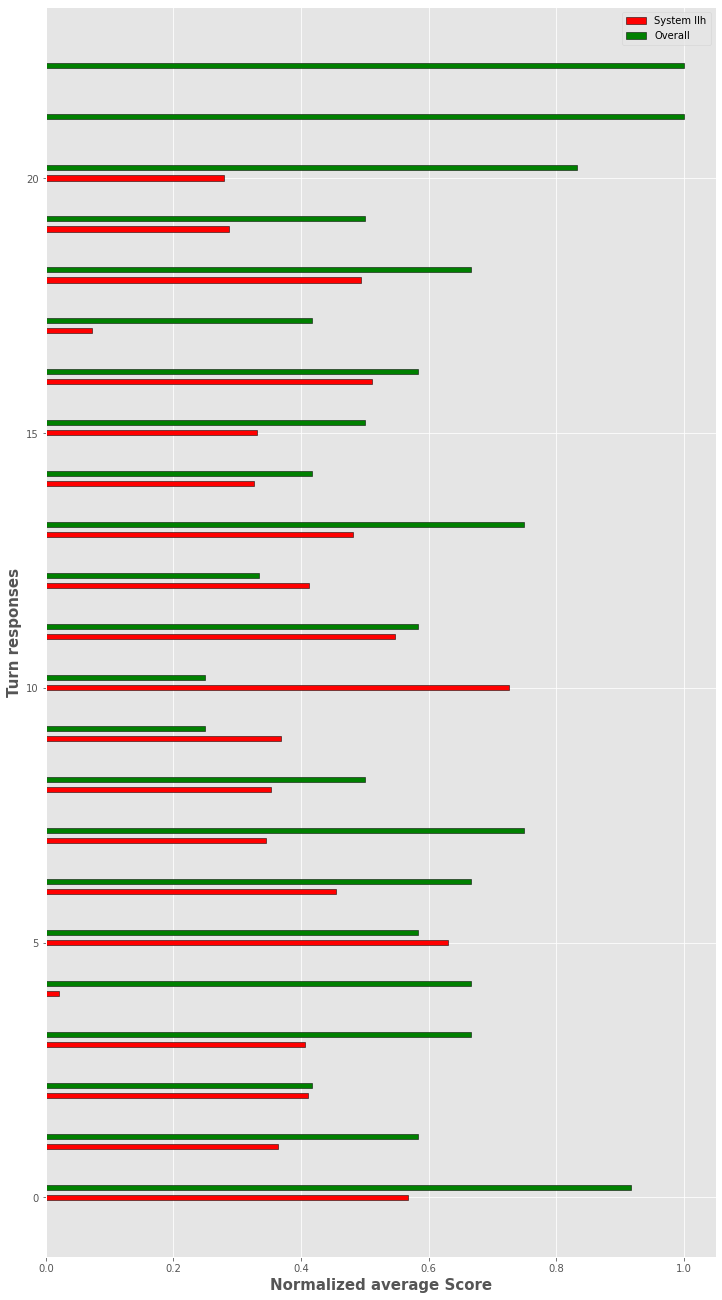

In [33]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Overall"
extend__with_bar(0.2, normalized_scores_overall, score_name, plt, ["g"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()


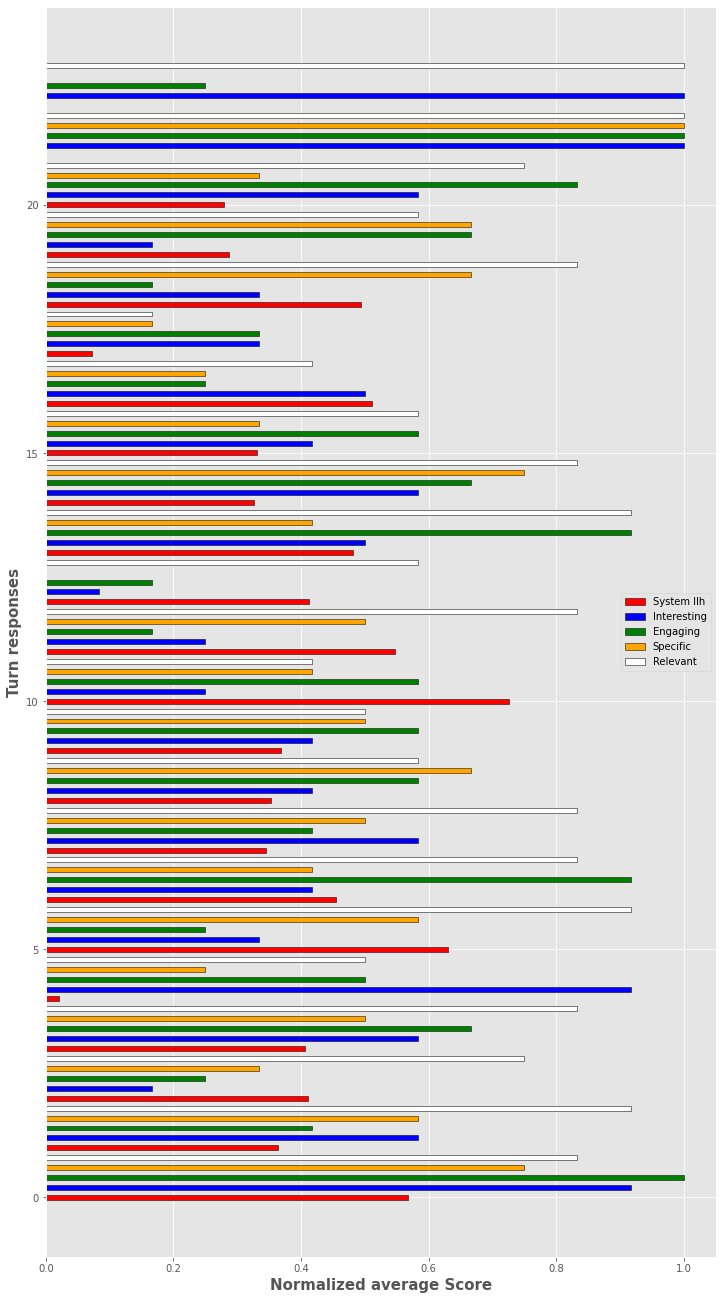

In [34]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)


score_name = "Interesting"
extend__with_bar(0.2,normalized_scores_interesting, score_name, plt, ["b"], used_colors)
score_name = "Engaging"
extend__with_bar(0.4,normalized_scores_engaging, score_name, plt, ["g"], used_colors)
score_name = "Specific"
extend__with_bar(0.6,normalized_scores_specific, score_name, plt, ["orange"], used_colors)
score_name = "Relevant"
extend__with_bar(0.8,normalized_scores_relevant, score_name, plt, ["w"], used_colors)


plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()



In [35]:
rows = []

score_name_y = "Overall Human Rating"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Interesting"
mae, mse, rmse = get_mean_error_area(normalized_scores_interesting, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Engaging"
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Specific"
normalized_scores_specific 
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Relevant"
mae, mse, rmse = get_mean_error_area(normalized_scores_relevant,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Correct"
mae, mse, rmse = get_mean_error_area(normalized_scores_correct, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Semantically Appropriate"
mae, mse, rmse = get_mean_error_area(normalized_scores_semantic, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Understandable" 
mae, mse, rmse = get_mean_error_area(normalized_scores_understandable,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Fluent"
mae, mse, rmse = get_mean_error_area(normalized_scores_fluent,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})



df_auto_scores = pd.DataFrame(rows)
df_auto_scores.head()

file = annotation_path+"/"+score_name_x+"_correlation.csv"
df_auto_scores.to_csv(file, index=False)

### MLM likelihood of the language model

In [36]:
score_name_x = "MLM llh"

auto_turn_scores = {}

# We take the turns and scores from the first excel 
# as we assume that the automated data is the same
# for all annotated excel files
for path in basepath.glob('*.csv'):
    df = pd.read_csv(path)
    if 'Turn' in df:
        print(path)
        js = df.to_json(orient = 'records')
        for turn in json.loads(js):
            if turn['Overall Human Rating']:
                get_score_for_turns(turn, auto_turn_scores, score_name_x)

        break ### after the first file we are done

# Check if we have the same numer of keys and make them compatible
for key in normalized_scores_overall:
    if not auto_turn_scores.get(key):
        auto_turn_scores[key]=0
print(len(auto_turn_scores), auto_turn_scores)
print(len(normalized_scores_overall), normalized_scores_overall)


/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g1-piek/scenario2/2021-12-10-09_35_57_turns57_thomas.csv
23 {4: 0.6512246564, 6: 0.6282802278, 8: 0.656767248, 10: 0.5743481847, 12: 0.3449977243, 14: 0.8297420465, 21: 0.632569667, 23: 0.7349087569, 25: 0.6739754111, 27: 0.5793280719, 29: 0.8839193881, 31: 0.8034780156, 33: 0.7028977232, 40: 0.7154284976, 42: 0.639216284, 44: 0.4869914539, 46: 0.6249509169, 48: 0.2641138832, 50: 0.7145343515, 52: 0.5145429336, 54: 0.396194616, 2: 0, 16: 0}
23 {4: 0.9166666666666667, 6: 0.5833333333333334, 8: 0.41666666666666663, 10: 0.6666666666666666, 12: 0.6666666666666666, 14: 0.5833333333333334, 21: 0.6666666666666666, 23: 0.75, 25: 0.5, 27: 0.25, 29: 0.25, 31: 0.5833333333333334, 33: 0.33333333333333337, 40: 0.75, 42: 0.41666666666666663, 44: 0.5, 46: 0.5833333333333334, 48: 0.41666666666666663, 50: 0.6666666666666666, 52: 0.5, 54: 0.8333333333333333, 2: 1.0, 16: 1.0}


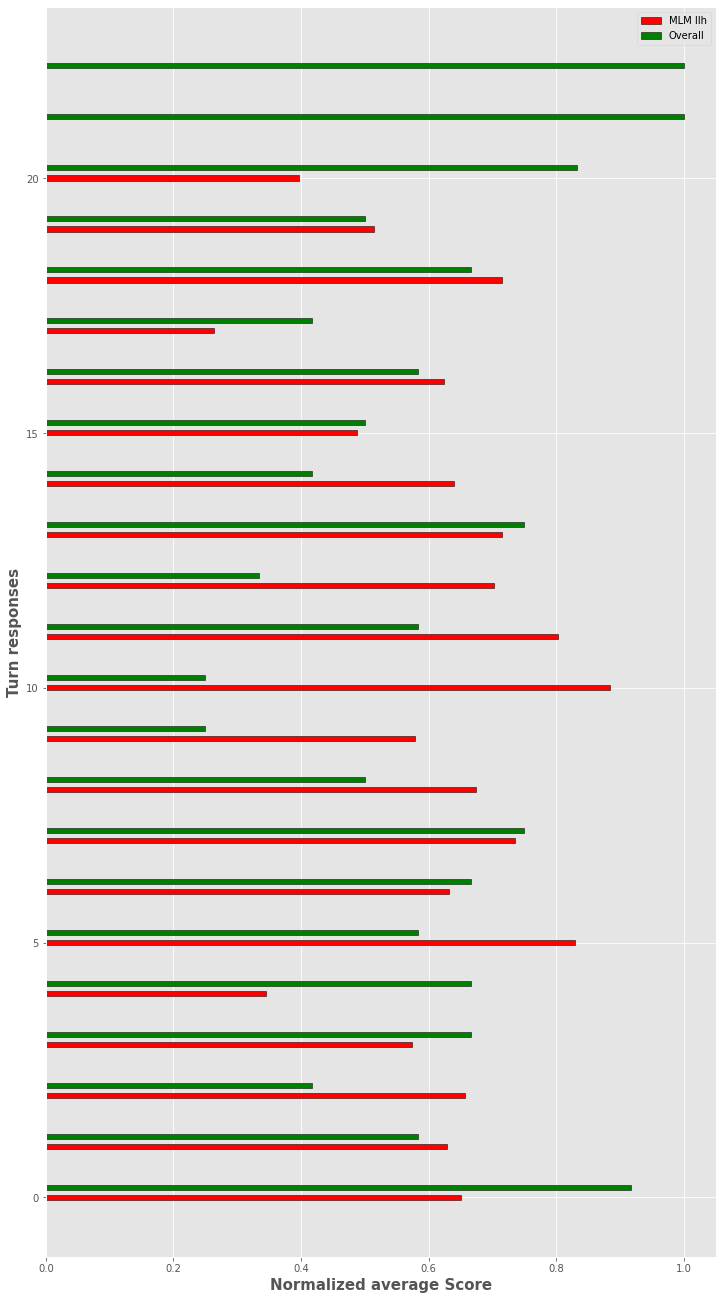

In [37]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Overall"
extend__with_bar(0.2, normalized_scores_overall, score_name, plt, ["g"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

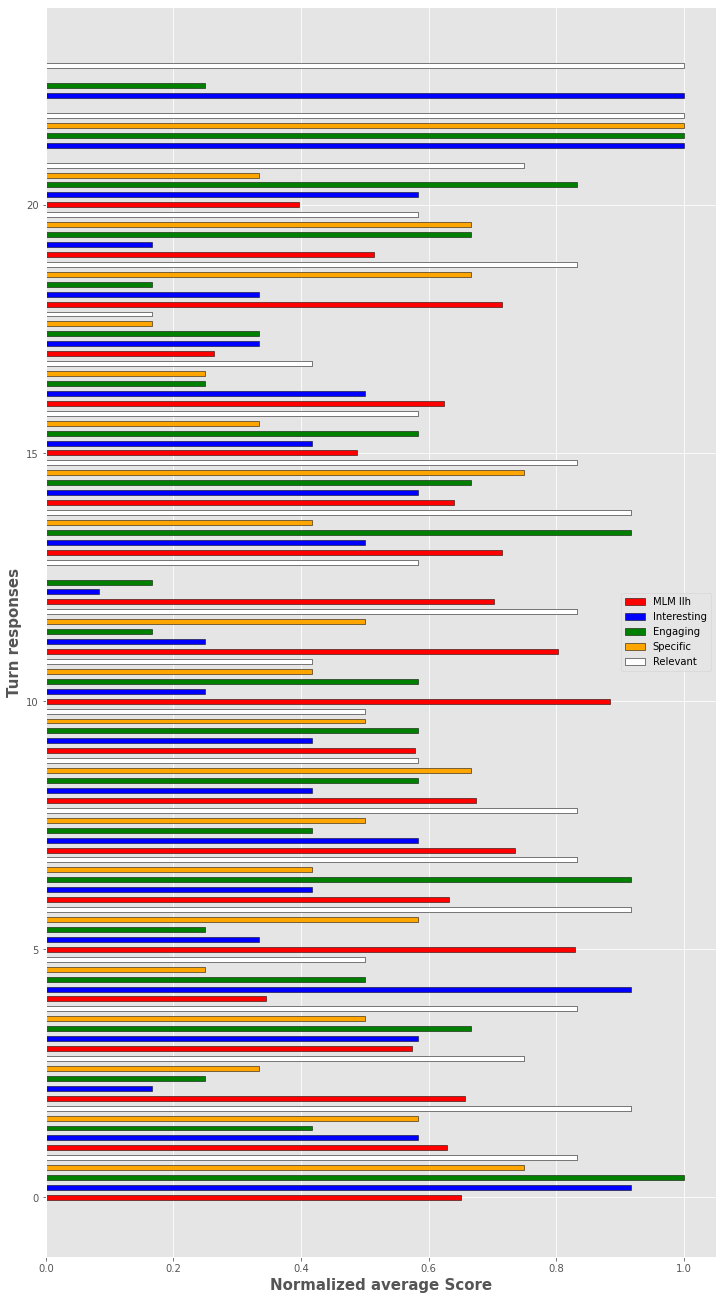

In [38]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Interesting"
extend__with_bar(0.2,normalized_scores_interesting, score_name, plt, ["b"], used_colors)
score_name = "Engaging"
extend__with_bar(0.4,normalized_scores_engaging, score_name, plt, ["g"], used_colors)
score_name = "Specific"
extend__with_bar(0.6,normalized_scores_specific, score_name, plt, ["orange"], used_colors)
score_name = "Relevant"
extend__with_bar(0.8,normalized_scores_relevant, score_name, plt, ["w"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

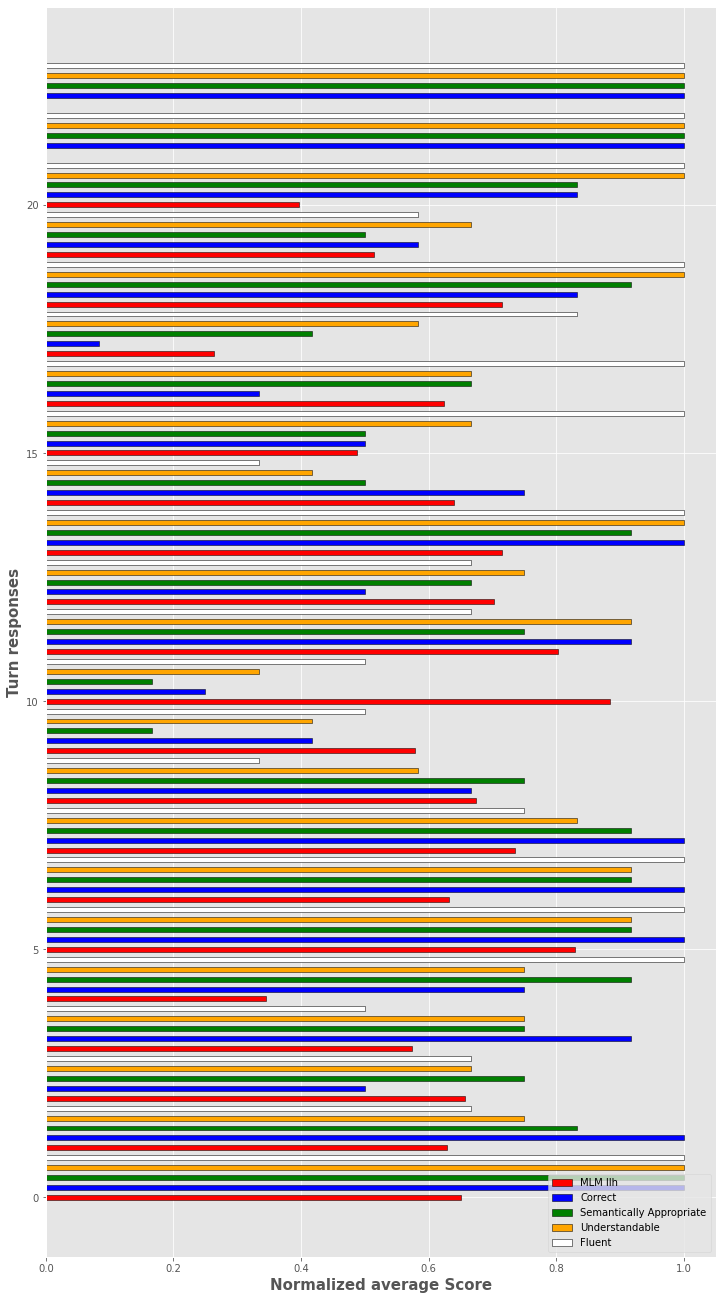

In [39]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Correct"
extend__with_bar(0.2,normalized_scores_correct, score_name, plt, ["b"], used_colors)
score_name = "Semantically Appropriate"
extend__with_bar(0.4,normalized_scores_semantic, score_name, plt, ["g"], used_colors)
score_name = "Understandable"
extend__with_bar(0.6,normalized_scores_understandable, score_name, plt, ["orange"], used_colors)
score_name = "Fluent"
extend__with_bar(0.8,normalized_scores_fluent, score_name, plt, ["w"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

In [40]:
rows = []

score_name_y = "Overall Human Rating"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Interesting"
mae, mse, rmse = get_mean_error_area(normalized_scores_interesting, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Engaging"
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Specific"
normalized_scores_specific 
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Relevant"
mae, mse, rmse = get_mean_error_area(normalized_scores_relevant,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Correct"
mae, mse, rmse = get_mean_error_area(normalized_scores_correct, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Semantically Appropriate"
mae, mse, rmse = get_mean_error_area(normalized_scores_semantic, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Understandable" 
mae, mse, rmse = get_mean_error_area(normalized_scores_understandable,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Fluent"
mae, mse, rmse = get_mean_error_area(normalized_scores_fluent,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

df_auto_scores = pd.DataFrame(rows)
df_auto_scores.head()

file = annotation_path+"/"+score_name_x+"_correlation.csv"
df_auto_scores.to_csv(file, index=False)

### USR DLcontext

In [41]:
score_name_x = "USR DLcontext"

auto_turn_scores = {}

# We take the turns and scores from the first excel 
# as we assume that the automated data is the same
# for all annotated excel files
for path in basepath.glob('*.csv'):
    df = pd.read_csv(path)
    if 'Turn' in df:
        print(path)
        js = df.to_json(orient = 'records')
        for turn in json.loads(js):
            if turn['Overall Human Rating']:
                get_score_for_turns(turn, auto_turn_scores, score_name_x)

        break ### after the first file we are done

### Check if we have the same numer of keys and make them compatible
for key in normalized_scores_overall:
    if not auto_turn_scores.get(key):
        auto_turn_scores[key]=0
print(len(auto_turn_scores), auto_turn_scores)
print(len(normalized_scores_overall), normalized_scores_overall)

/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g1-piek/scenario2/2021-12-10-09_35_57_turns57_thomas.csv
23 {4: 0.9121886, 6: 0.003617899, 8: 0.12849143, 10: 0.9960758, 12: 0.9908444, 14: 0.9974281, 21: 0.9639224, 23: 0.6832265, 25: 0.98112196, 27: 0.078096494, 29: 0.997244, 31: 0.99713945, 33: 0.995588, 40: 0.029860621, 42: 0.048327632, 44: 0.9269139, 46: 0.99838245, 48: 0.99413645, 50: 0.998393, 52: 0.37350133, 54: 0.99539506, 2: 0, 16: 0}
23 {4: 0.9166666666666667, 6: 0.5833333333333334, 8: 0.41666666666666663, 10: 0.6666666666666666, 12: 0.6666666666666666, 14: 0.5833333333333334, 21: 0.6666666666666666, 23: 0.75, 25: 0.5, 27: 0.25, 29: 0.25, 31: 0.5833333333333334, 33: 0.33333333333333337, 40: 0.75, 42: 0.41666666666666663, 44: 0.5, 46: 0.5833333333333334, 48: 0.41666666666666663, 50: 0.6666666666666666, 52: 0.5, 54: 0.8333333333333333, 2: 1.0, 16: 1.0}


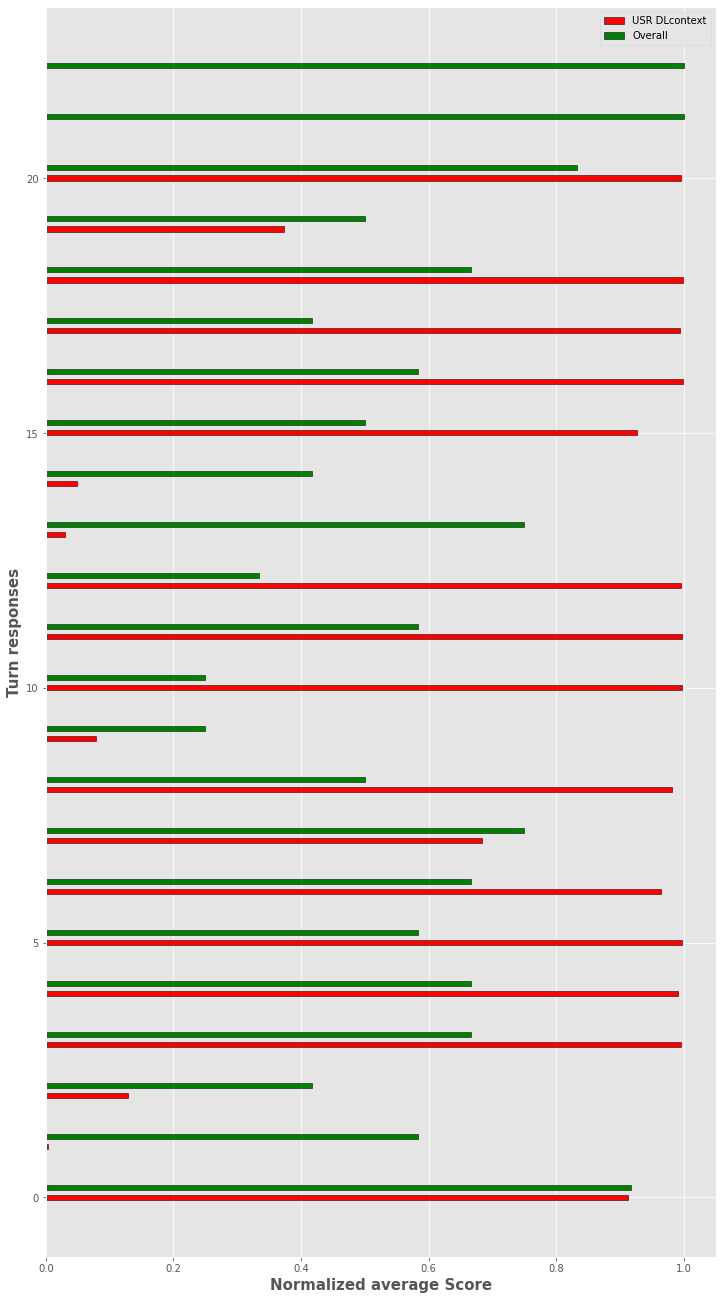

In [42]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Overall"
extend__with_bar(0.2, normalized_scores_overall, score_name, plt, ["g"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

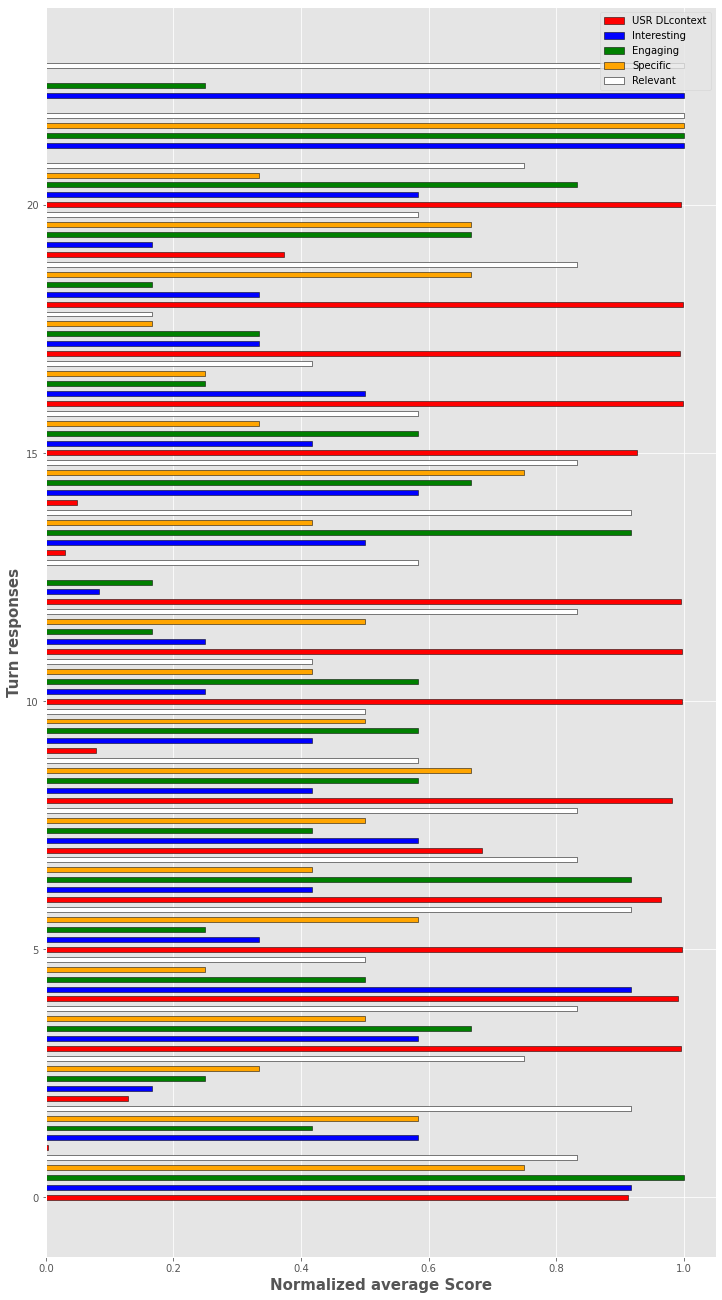

In [43]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Interesting"
extend__with_bar(0.2,normalized_scores_interesting, score_name, plt, ["b"], used_colors)
score_name = "Engaging"
extend__with_bar(0.4,normalized_scores_engaging, score_name, plt, ["g"], used_colors)
score_name = "Specific"
extend__with_bar(0.6,normalized_scores_specific, score_name, plt, ["orange"], used_colors)
score_name = "Relevant"
extend__with_bar(0.8,normalized_scores_relevant, score_name, plt, ["w"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

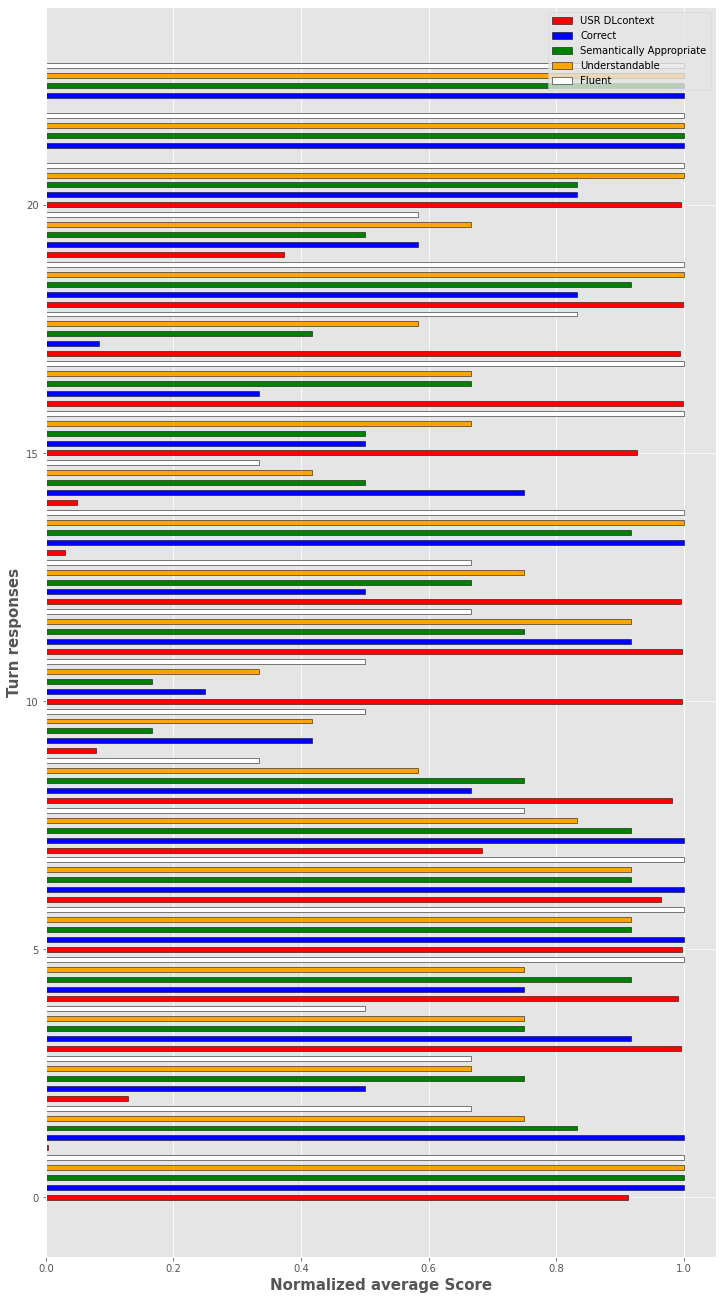

In [44]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Correct"
extend__with_bar(0.2,normalized_scores_correct, score_name, plt, ["b"], used_colors)
score_name = "Semantically Appropriate"
extend__with_bar(0.4,normalized_scores_semantic, score_name, plt, ["g"], used_colors)
score_name = "Understandable"
extend__with_bar(0.6,normalized_scores_understandable, score_name, plt, ["orange"], used_colors)
score_name = "Fluent"
extend__with_bar(0.8,normalized_scores_fluent, score_name, plt, ["w"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

In [45]:
rows = []

score_name_y = "Overall Human Rating"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Interesting"
mae, mse, rmse = get_mean_error_area(normalized_scores_interesting, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Engaging"
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Specific"
normalized_scores_specific 
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Relevant"
mae, mse, rmse = get_mean_error_area(normalized_scores_relevant,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Correct"
mae, mse, rmse = get_mean_error_area(normalized_scores_correct, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Semantically Appropriate"
mae, mse, rmse = get_mean_error_area(normalized_scores_semantic, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Understandable" 
mae, mse, rmse = get_mean_error_area(normalized_scores_understandable,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Fluent"
mae, mse, rmse = get_mean_error_area(normalized_scores_fluent,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

df_auto_scores = pd.DataFrame(rows)
df_auto_scores.head()

file = annotation_path+"/"+score_name_x+"_correlation.csv"
df_auto_scores.to_csv(file, index=False)

### USR DLfact

In [46]:
score_name_x = "USR DLfact"

auto_turn_scores = {}

# We take the turns and scores from the first excel 
# as we assume that the automated data is the same
# for all annotated excel files
for path in basepath.glob('*.csv'):
    df = pd.read_csv(path)
    if 'Turn' in df:
        print(path)
        js = df.to_json(orient = 'records')
        for turn in json.loads(js):
            if turn['Overall Human Rating']:
                get_score_for_turns(turn, auto_turn_scores, score_name_x)

        break ### after the first file we are done

### Check if we have the same numer of keys and make them compatible
for key in normalized_scores_overall:
    if not auto_turn_scores.get(key):
        auto_turn_scores[key]=0
print(len(auto_turn_scores), auto_turn_scores)
print(len(normalized_scores_overall), normalized_scores_overall)



/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g1-piek/scenario2/2021-12-10-09_35_57_turns57_thomas.csv
23 {4: 0.7285426, 6: 0.66868496, 8: 0.9159797, 10: 0.63530654, 12: 0.4902212, 14: 0.9956084, 21: 0.52162325, 23: 0.9918304, 25: 0.6209001, 27: 0.6409775, 29: 0.99682677, 31: 0.9967476, 33: 0.99632585, 40: 0.9337259, 42: 0.6446155, 44: 0.6751252, 46: 0.61695576, 48: 0.9806182, 50: 0.39274785, 52: 0.44261116, 54: 0.18052584, 2: 0, 16: 0}
23 {4: 0.9166666666666667, 6: 0.5833333333333334, 8: 0.41666666666666663, 10: 0.6666666666666666, 12: 0.6666666666666666, 14: 0.5833333333333334, 21: 0.6666666666666666, 23: 0.75, 25: 0.5, 27: 0.25, 29: 0.25, 31: 0.5833333333333334, 33: 0.33333333333333337, 40: 0.75, 42: 0.41666666666666663, 44: 0.5, 46: 0.5833333333333334, 48: 0.41666666666666663, 50: 0.6666666666666666, 52: 0.5, 54: 0.8333333333333333, 2: 1.0, 16: 1.0}


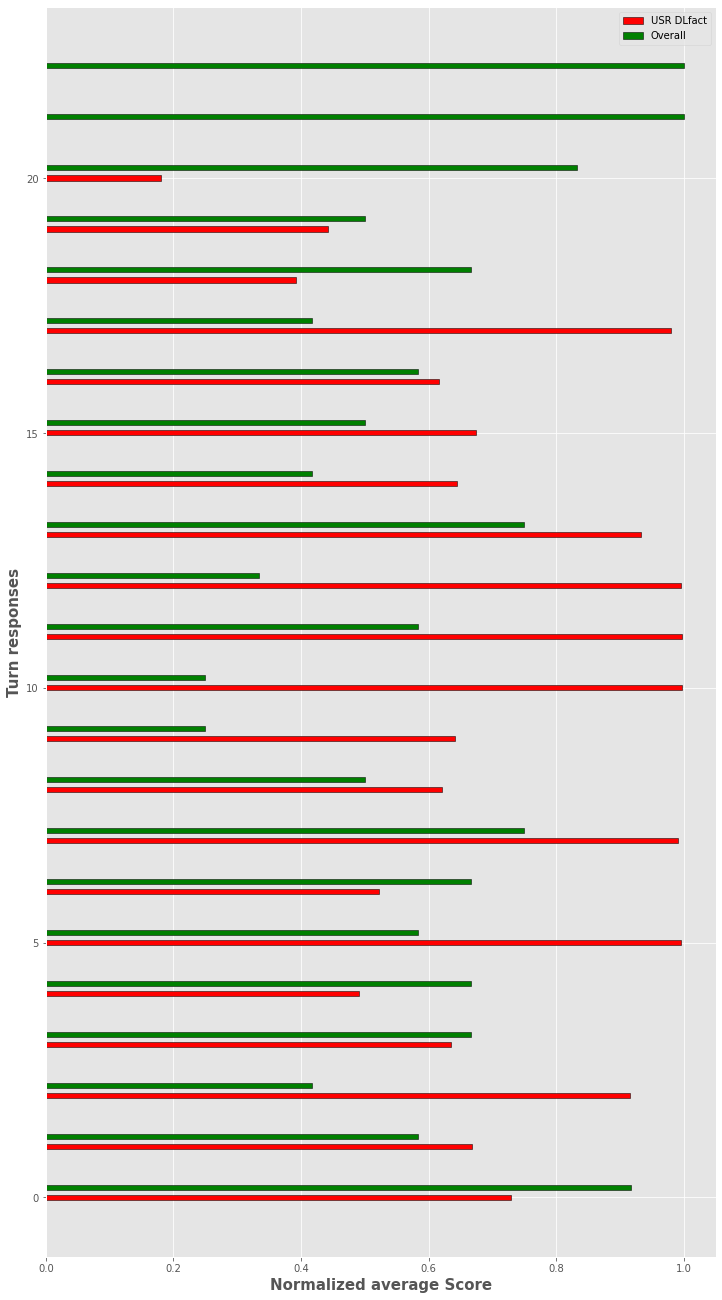

In [47]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Overall"
extend__with_bar(0.2, normalized_scores_overall, score_name, plt, ["g"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

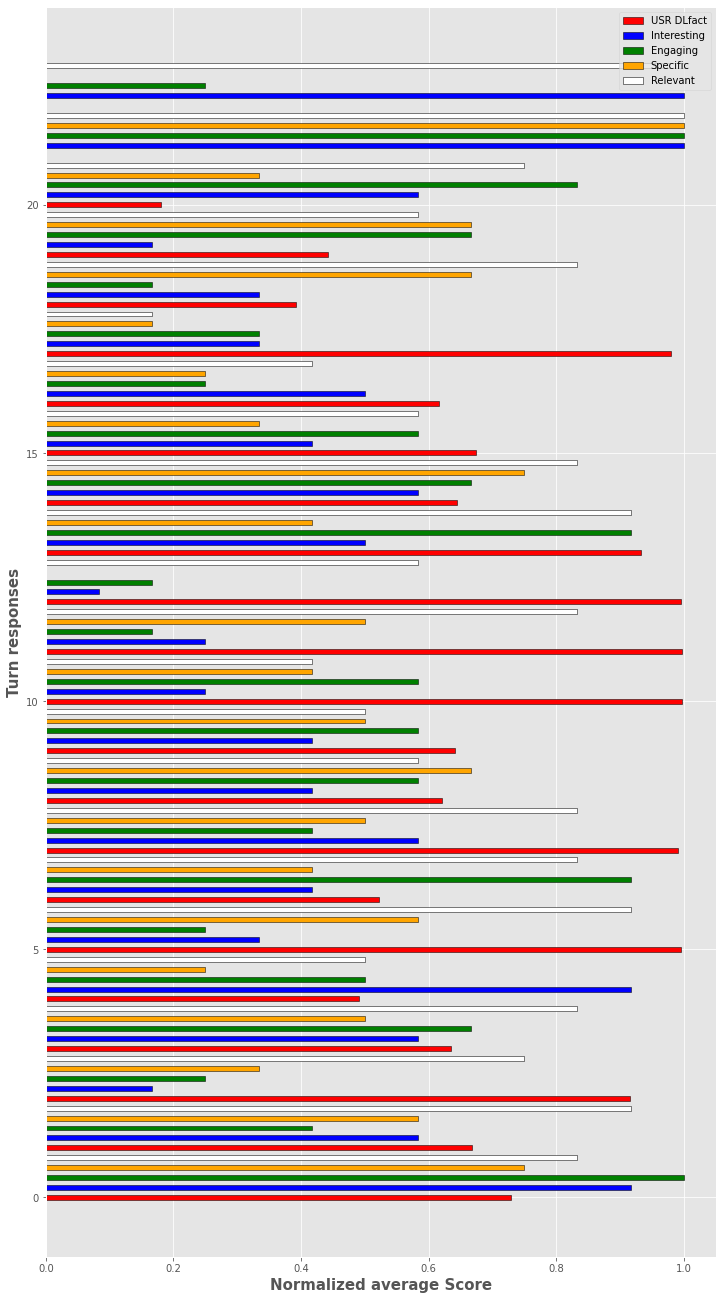

In [48]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Interesting"
extend__with_bar(0.2,normalized_scores_interesting, score_name, plt, ["b"], used_colors)
score_name = "Engaging"
extend__with_bar(0.4,normalized_scores_engaging, score_name, plt, ["g"], used_colors)
score_name = "Specific"
extend__with_bar(0.6,normalized_scores_specific, score_name, plt, ["orange"], used_colors)
score_name = "Relevant"
extend__with_bar(0.8,normalized_scores_relevant, score_name, plt, ["w"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

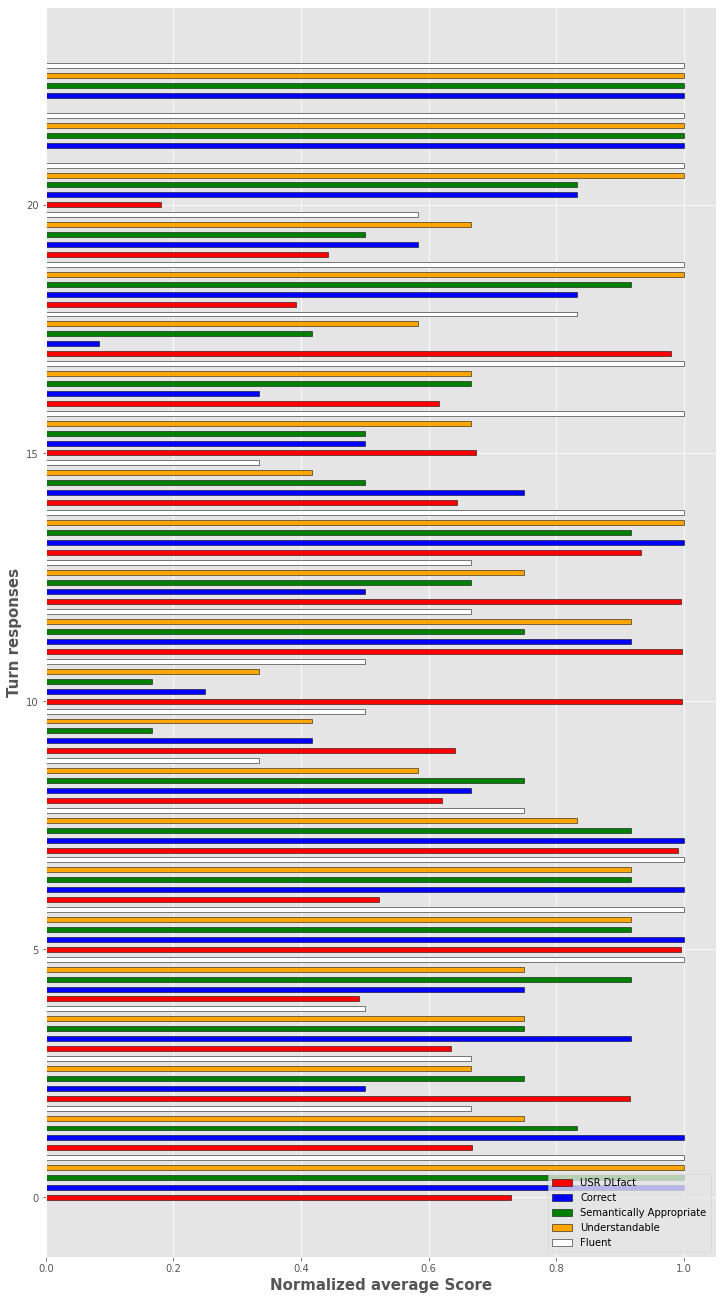

In [49]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Correct"
extend__with_bar(0.2,normalized_scores_correct, score_name, plt, ["b"], used_colors)
score_name = "Semantically Appropriate"
extend__with_bar(0.4,normalized_scores_semantic, score_name, plt, ["g"], used_colors)
score_name = "Understandable"
extend__with_bar(0.6,normalized_scores_understandable, score_name, plt, ["orange"], used_colors)
score_name = "Fluent"
extend__with_bar(0.8,normalized_scores_fluent, score_name, plt, ["w"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

In [50]:
rows = []

score_name_y = "Overall Human Rating"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Interesting"
mae, mse, rmse = get_mean_error_area(normalized_scores_interesting, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Engaging"
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Specific"
normalized_scores_specific 
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Relevant"
mae, mse, rmse = get_mean_error_area(normalized_scores_relevant,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Correct"
mae, mse, rmse = get_mean_error_area(normalized_scores_correct, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Semantically Appropriate"
mae, mse, rmse = get_mean_error_area(normalized_scores_semantic, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Understandable" 
mae, mse, rmse = get_mean_error_area(normalized_scores_understandable,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Fluent"
mae, mse, rmse = get_mean_error_area(normalized_scores_fluent,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

df_auto_scores = pd.DataFrame(rows)
df_auto_scores.head()

file = annotation_path+"/"+score_name_x+"_correlation.csv"
df_auto_scores.to_csv(file, index=False)

## End of notebook